# supernodes

The procedure of combining public transportation stops into supernodes.

Requires:
1. `data/preprocessed/stops.json`

Produces:
1. `data/supernodes/supernodes.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Set, Tuple

import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import stops_fpath, supernodes_fpath

plt.style.use('seaborn-whitegrid')

In [3]:
stops = pd.read_json(stops_fpath)

stops.head(2)

,type,id,name,lat,lon
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671
1,tram,16367,Пр. Солидарности,59.911857,30.499882


In [4]:
coords = stops.set_index('id')[['lat', 'lon']]

coords.head(2)

,lat,lon
id,,
16396,59.908881,30.494671
16367,59.911857,30.499882


In [5]:
distances = get_earth_distances(coords.values, coords.values)

distances.shape

(7660, 7660)

In [6]:
th = 0.1

closeness_adj_mx = (distances <= th).astype(int)
closeness_graph = nx.from_numpy_array(closeness_adj_mx)

closeness_graph = nx.relabel_nodes(closeness_graph, stops['id'].to_dict())

supernodes = sorted(nx.connected_components(closeness_graph), key=len, reverse=True)

len(supernodes)

3226

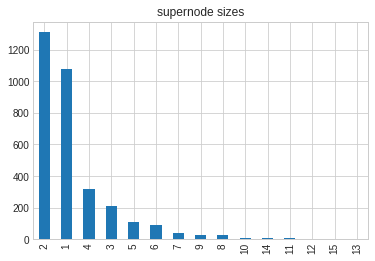

In [7]:
supernode_sizes = pd.Series(supernodes).apply(len).value_counts()

supernode_sizes.plot(kind='bar')
plt.title('supernode sizes');

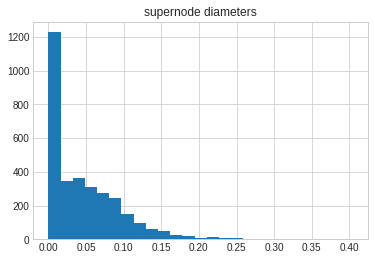

In [8]:
def supernode_diameter(supernode: Set[int]) -> float:
    coords_ = coords.loc[supernode, ['lat', 'lon']].values
    distances_ = get_earth_distances(coords_, coords_)
    diameter = distances_.max()
    
    return diameter


supernode_diameters = [supernode_diameter(supernode) for supernode in supernodes]

plt.hist(supernode_diameters, bins=25)
plt.title('supernode diameters');

In [9]:
supernodes_json = []

for i, supernode in enumerate(supernodes):
    lat, lon = coords.loc[supernode, ['lat', 'lon']].mean()
    diameter = supernode_diameter(supernode)
    types = stops.loc[stops['id'].isin(supernode), 'type'].unique().tolist()
    
    supernodes_json.append({
        'id': i,
        'stops': list(supernode),
        'diameter': diameter,
        'types': types,
        'lat': lat,
        'lon': lon,
    })

In [10]:
save_json(supernodes_json, supernodes_fpath)

In [11]:
stop2supernode = {
    stop: i
    for i, supernode in enumerate(supernodes)
    for stop in supernode
}

stops['supernode'] = stops['id'].map(stop2supernode)

stops.head(2)

,type,id,name,lat,lon,supernode
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,626
1,tram,16367,Пр. Солидарности,59.911857,30.499882,836


In [12]:
stops_json = [row.to_dict() for _, row in stops.iterrows()]

save_json(stops_json, stops_fpath)